In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/img.zip

Streaming output truncated to the last 5000 lines.
  inflating: img/Woven_Dolphin_Shorts/img_00000027.jpg  
  inflating: img/Woven_Dolphin_Shorts/img_00000028.jpg  
  inflating: img/Woven_Dolphin_Shorts/img_00000029.jpg  
  inflating: img/Woven_Dolphin_Shorts/img_00000030.jpg  
  inflating: img/Woven_Dolphin_Shorts/img_00000031.jpg  
  inflating: img/Woven_Dolphin_Shorts/img_00000032.jpg  
  inflating: img/Woven_Dolphin_Shorts/img_00000033.jpg  
  inflating: img/Woven_Dolphin_Shorts/img_00000034.jpg  
  inflating: img/Woven_Dolphin_Shorts/img_00000035.jpg  
  inflating: img/Woven_Dolphin_Shorts/img_00000036.jpg  
  inflating: img/Woven_Dolphin_Shorts/img_00000037.jpg  
   creating: img/Woven_Drawstring_Joggers/
  inflating: img/Woven_Drawstring_Joggers/img_00000001.jpg  
  inflating: img/Woven_Drawstring_Joggers/img_00000002.jpg  
  inflating: img/Woven_Drawstring_Joggers/img_00000003.jpg  
  inflating: img/Woven_Drawstring_Joggers/img_00000004.jpg  
  inflating: img/Woven_Drawstring_J

In [3]:
!pip install fastai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
from fastai.vision.data import ImageDataLoaders
from fastai.vision.all import *
from fastai.imports import *
import gc 
import pandas as pd
import fastai

%matplotlib inline

In [15]:
data = ImageDataLoaders.from_csv(path='',
                                 csv_fname='train_label.csv',
                                 label_col='category_name',  # Assuming you want to use category_name as label
                                 fn_col='image_name', 
                                 item_tfms=Resize(300),
                                 batch_tfms=aug_transforms(size=224, min_scale=0.9),
                                 valid_pct=0.1,
                                 splitter=RandomSplitter(seed=42),
                                 num_workers=0)

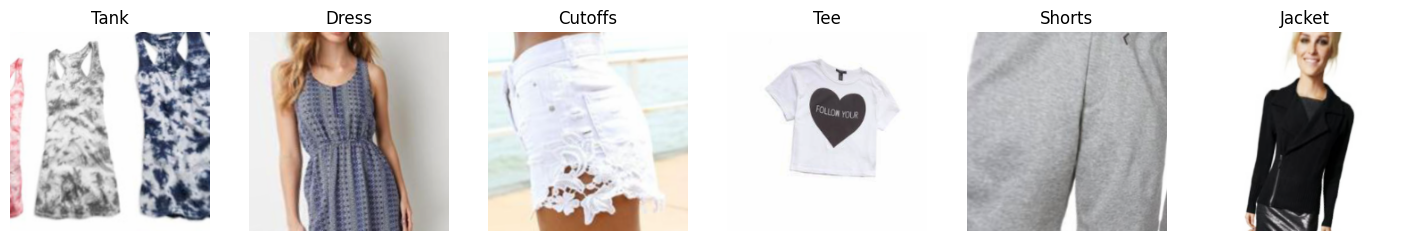

In [16]:
data.show_batch(max_n=6, nrows=1)

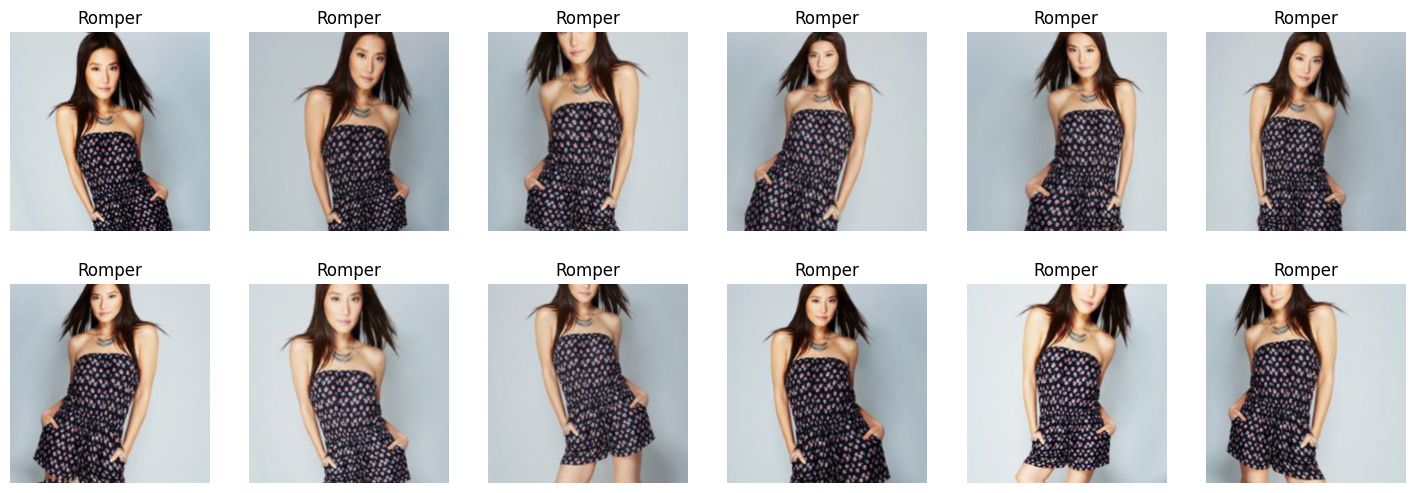

In [8]:
data.show_batch(max_n=12, nrows=2, unique=True)

In [21]:
# Create a Convolutional Neural Network learner with a ResNet34 architecture
model = cnn_learner(dls=data, arch=resnet34, loss_func=CrossEntropyLossFlat(), metrics=accuracy, pretrained=True)

# Fine-tune the model for 2 epochs
model.fine_tune(epochs=2)

# Save the trained model with a name
model.save('stage-1_resnet34')

epoch,train_loss,valid_loss,accuracy,time
0,1.623914,1.449260,0.577908,17:47


epoch,train_loss,valid_loss,accuracy,time
0,1.307497,1.206950,0.648934,18:35
1,1.128490,1.068154,0.684925,18:32


Path('models/stage-1_resnet34.pth')

In [23]:
gc.collect()
torch.cuda.empty_cache()

epoch,train_loss,valid_loss,accuracy,time


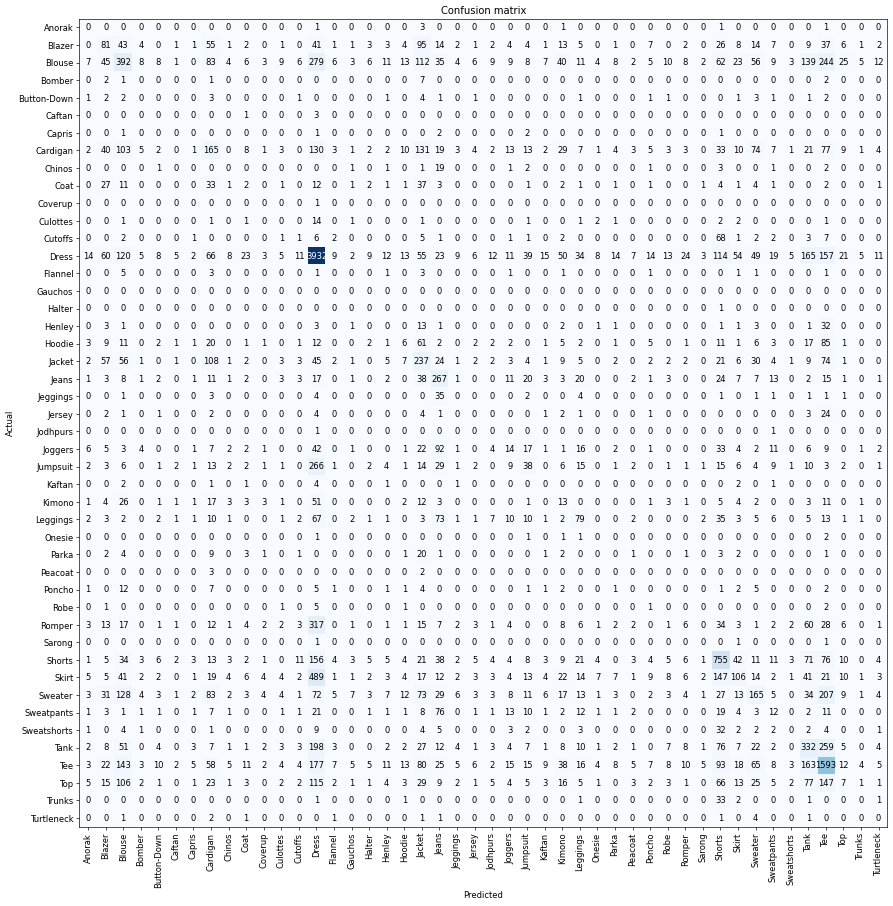

In [24]:
# Create a classification interpretation object from the learner
classification_interpreter = ClassificationInterpretation.from_learner(learn)

# Define the size and resolution of the confusion matrix
confusion_matrix_dimensions = (15,15)
resolution = 60

# Plot the confusion matrix
classification_interpreter.plot_confusion_matrix(figsize=confusion_matrix_dimensions, dpi=resolution)

In [25]:
# Determine the most confused classes with a minimum value of 70
classification_interpreter.most_confused(min_val=70)

[('Skirt', 'Dress', 489),
 ('Romper', 'Dress', 317),
 ('Blouse', 'Dress', 279),
 ('Jumpsuit', 'Dress', 266),
 ('Tank', 'Tee', 259),
 ('Blouse', 'Tee', 244),
 ('Sweater', 'Tee', 207),
 ('Tank', 'Dress', 198),
 ('Tee', 'Dress', 177),
 ('Dress', 'Tank', 165),
 ('Tee', 'Tank', 163),
 ('Dress', 'Tee', 157),
 ('Shorts', 'Dress', 156),
 ('Skirt', 'Shorts', 147),
 ('Top', 'Tee', 147),
 ('Tee', 'Blouse', 143),
 ('Blouse', 'Tank', 139),
 ('Cardigan', 'Jacket', 131),
 ('Cardigan', 'Dress', 130),
 ('Sweater', 'Blouse', 128),
 ('Dress', 'Blouse', 120),
 ('Top', 'Dress', 115),
 ('Dress', 'Shorts', 114),
 ('Blouse', 'Jacket', 112),
 ('Jacket', 'Cardigan', 108),
 ('Top', 'Blouse', 106),
 ('Cardigan', 'Blouse', 103),
 ('Blazer', 'Jacket', 95),
 ('Tee', 'Shorts', 93),
 ('Joggers', 'Jeans', 92),
 ('Hoodie', 'Tee', 85),
 ('Blouse', 'Cardigan', 83),
 ('Sweater', 'Cardigan', 83),
 ('Tee', 'Jacket', 80),
 ('Cardigan', 'Tee', 77),
 ('Top', 'Tank', 77),
 ('Shorts', 'Tee', 76),
 ('Sweatpants', 'Jeans', 76),
 ('

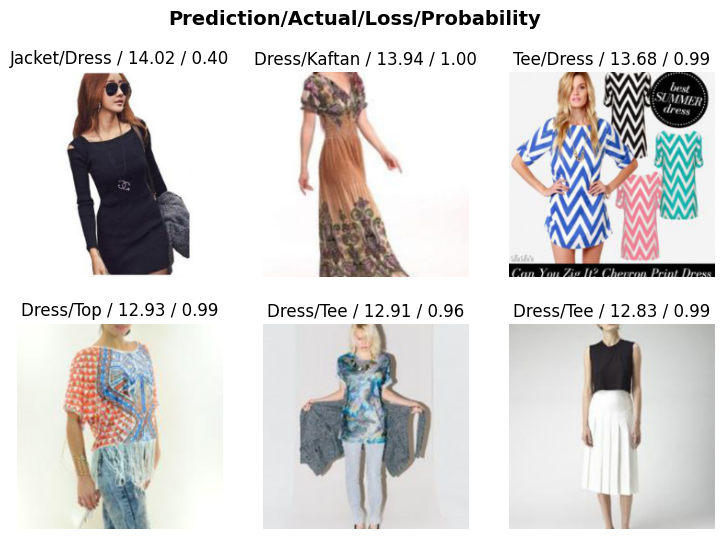

In [28]:
# Visualize the top 6 losses in a grid with 2 rows
classification_interpreter.plot_top_losses(6, nrows=2)

In [22]:
# Now you want to unfreeze and continue training
model.unfreeze()

SuggestedLRs(minimum=1.9054607491852948e-07, steep=6.309573450380412e-07, valley=9.12010818865383e-07, slide=0.0063095735386013985)

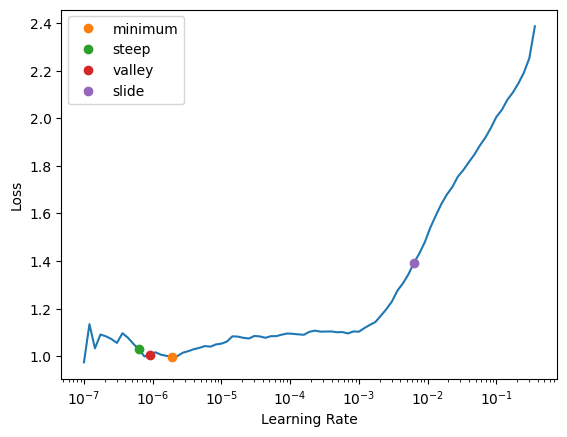

In [29]:
model.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [30]:
model.fit_one_cycle(4, lr_max=slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.111961,1.099129,0.675605,18:45
1,1.049878,1.068182,0.686789,18:39
2,1.019563,1.044140,0.694102,18:42
3,0.988397,1.042598,0.695345,18:41


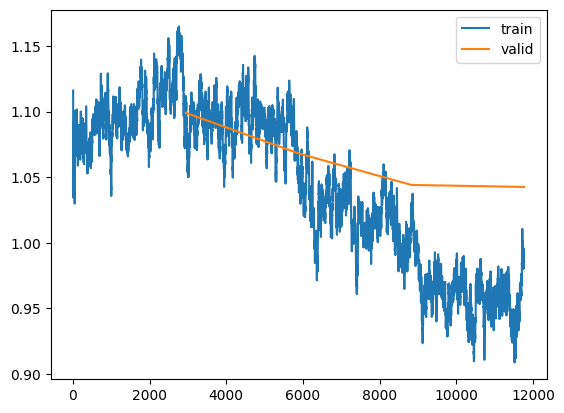

In [34]:
model.recorder.plot_loss()

In [32]:
modelname = model.model
modelname.cpu()
torch.save(modelname, 'bn_resnet34.pkl')

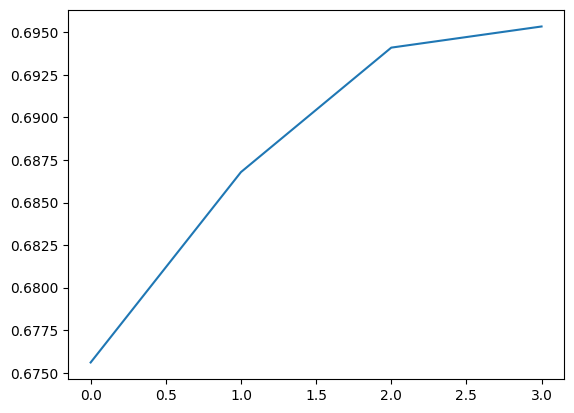

In [33]:
plt.plot(L(model.recorder.values).itemgot(2))

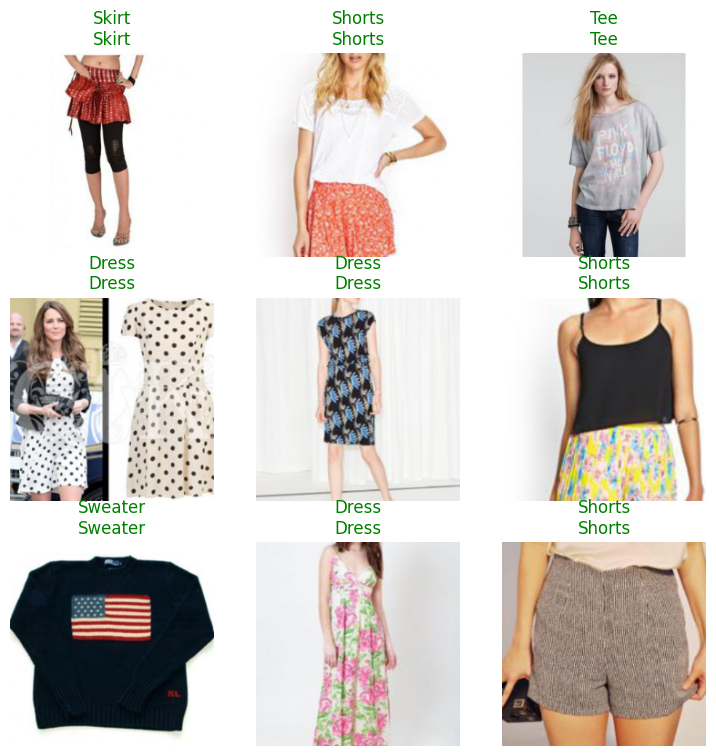

In [35]:
model.show_results()

In [39]:
test_img_data = ImageDataLoaders.from_csv('', csv_fname='test_label.csv',
                                 label_col='category_name',  # Assuming you want to use category_name as label
                                 fn_col='image_name',
                                 item_tfms=Resize(224), 
                                 #batch_tfms=Normalize.from_stats(*imagenet_stats),
                                 num_workers=0)

In [40]:
model.data = test_img_data
model.validate()

(#2) [1.0425981283187866,0.6953446269035339]

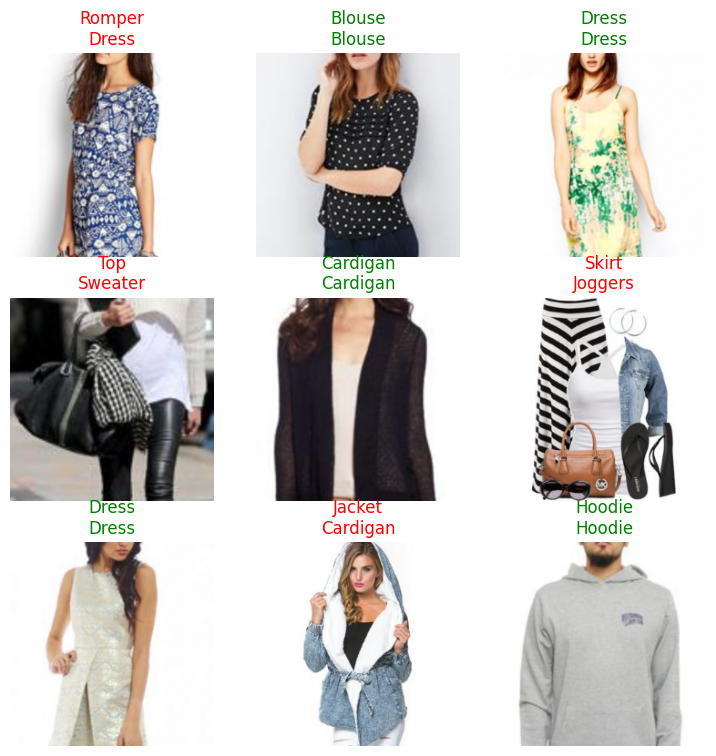

In [41]:
model.show_results()

In [42]:
def top_k_accuracy(pred, truth, k_values=(3,)):
    """Calculates the top-k accuracy for specified values of k"""

    highest_k = max(k_values)
    num_samples = truth.size(0)

    _, predictions = pred.topk(highest_k, 1, True, True)
    predictions = predictions.transpose(0, 1)
    correct_predictions = predictions.eq(truth.view(1, -1).expand_as(predictions))

    result = []
    for k in k_values:
        #print(correct_predictions[:k].contiguous().view(-1))
        correct_k = correct_predictions[:k].reshape(-1).float().sum(0, keepdim=True)
        result.append(correct_k.mul_(100.0 / num_samples))
    return result


In [43]:
output, target = model.get_preds()

In [44]:
print(top_k_accuracy(pred=output, truth=target))

[tensor([88.3902])]


In [46]:
print(top_k_accuracy(pred=output, truth=target, k_values=(5,)))

[tensor([93.9633])]


In [48]:
model.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      